# Step 2. Skimming outliers based on their location

In [5]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from geopy.distance import vincenty #distance of two points on an oblate spheroid
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split

import MAD_functions as mad #our library to find outliers based on MAD: median absolute deviation
import _pickle as pickle
import time

#from mpl_toolkits.basemap import Basemap

We assume that data entries that are very far away from the rest of the dataset will have characteristics and prices that do not reflect the market of the city we are considering, so we want to filter very isolated points in the outskirts.

In [6]:
#import data
data = pd.read_csv('step1_output.csv', sep=';')

We can plot with basemap, an extension of matplotlib, the data on a simple map. For faster drawing change resolution to 'l'

In [7]:
central_lat=np.mean(data.loc[:,('latitude')].values)
central_long=np.mean(data.loc[:,('longitude')].values)
min_lat=np.min((data.loc[:,('latitude')].values))
max_lat=np.max((data.loc[:,('latitude')].values))
min_long=np.min(data.loc[:,('longitude')].values)
max_long=np.max(data.loc[:,('longitude')].values)

In [8]:
fig1 = plt.figure(figsize=(10,10))
# setup of basemap stereographic projection
m = Basemap(llcrnrlat=min_lat-0.01,llcrnrlon=min_long-0.01,urcrnrlat=max_lat+0.01,urcrnrlon=max_long+0.01,
            resolution='f',projection='stere',area_thresh = 0.01, lat_0=central_lat, lon_0=central_long)
m.drawcoastlines()
m.fillcontinents(color=[0.8,0.8,0.8],lake_color='aqua',zorder=0)
m.drawmapboundary(fill_color='aqua')
x, y = m(data.loc[:,('longitude')].values,data.loc[:,('latitude')].values)
m.plot(x,y,'.',markersize=4,color='k',alpha=0.6,zorder=10)
m.drawparallels([min_lat,max_lat],labels=[0,1,1,0] )
m.drawmeridians([min_long,max_long],labels=[1,0,0,1] )
font = {'family' : 'Arial',
        'weight' : 'light',
        'size'   : 14}
plt.title('All data',fontsize=18)
plt.show()
fig1.savefig('geo_outliers\map_full.png',dpi=600)

NameError: name 'Basemap' is not defined

# Hyperparameters and how to detect the ouliers

We chose the number of neighbors to consider in order to compute the median distance of each point to the others according to the best score of the final regressor, so we consider the neighbor number an hyperparameter that can be tuned. 25 gave the best score for Barcelona, but of course this parameter should be tuned according to the specific geography when applying this method to another city.

The way we chose to detect the ouliers was to rely on the median absolute deviation, MAD, i.e. an error calculated on the median. Considering MAD and median is generally more robust than looking at mean and standard deviation when treating outliers.
In general we consider "good data" those whose distance from the others falls in the interval:

m-thesh x MAD<distance<m+thresh x MAD.

where m is the median, and thersh a threshold parameter.

Setting the value thresh to 8 seemed a good choice for 3 reasons:
1) With this value both in the case of the geo outliers and for the price outliers the distribution of data lost the "tails" but without losing a great amount of data.
2) This value gave good final score of the regressor.
3) If the distribution of distances was gaussian (not our case) a threshold of 8 would result in cutting above 5 sigma.

In [6]:
neighbors_number=25
thresh=8

# Nearest neighbors

We train a nearest neighbor algorithm to find the neighbors. We get a vector with the indeces of the n neighbors for each point.

Then we compute the median distance to the n neighbors found for each point and look at the distribution.

In [7]:
neigh = NearestNeighbors(n_neighbors=neighbors_number, metric='euclidean', n_jobs=-1)
#for each element we find the first n neighbors.
neigh.fit(data.loc[:,('latitude','longitude')])
distances=neigh.kneighbors(data.loc[:,('latitude','longitude')],neighbors_number, return_distance=False)#the distance returned 
#in this case would not have a real physical meaning

In [8]:
###Commented as it takes a while...
d_meters=np.zeros(distances.shape)
mean_distance=np.zeros(len(distances))
median_distance=np.zeros(len(distances))
t0=time.clock()
for i_a in distances[:,0]:
    lat_long_a=np.array([data.iloc[i_a].latitude, data.iloc[i_a].longitude])
    for i_b in np.linspace(0,neighbors_number-1,neighbors_number).astype(int):
        i_neigh=distances[i_a,i_b]
        lat_long_neigh=np.array([data.iloc[i_neigh].latitude, data.iloc[i_neigh].longitude])
        d_meters[i_a,i_b]=vincenty(lat_long_a,lat_long_neigh).meters
    median_distance[i_a]=np.median(d_meters[i_a,:])
t1=time.clock()
print 'elapsed time %f'% (t1-t0)

elapsed time 592.447298


In [9]:
#since the previous code takes a while let's save the results so it doesn't have to be re-run
pickle.dump( d_meters, open( "geo_outliers\save_"+str(neighbors_number)+"all.p", "wb" ) )
pickle.dump( median_distance, open( "geo_outliers\save_"+str(neighbors_number)+"median.p", "wb" ) )

In [10]:
#and here we retrieve them (if needed)
d_meters = pickle.load( open( "geo_outliers\save_"+str(neighbors_number)+"all.p", "rb" ) )
median_distance = pickle.load( open( "geo_outliers\save_"+str(neighbors_number)+"median.p", "rb" ) )

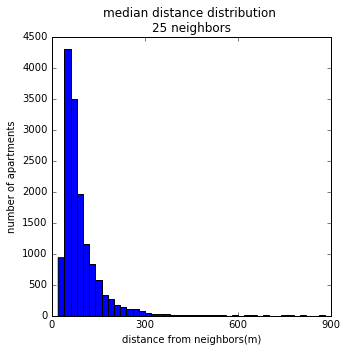

In [36]:
# Plot mean and median distribution of the distance of first n neighbors to each point
fig_a = plt.figure(figsize=(5,5))
ax1=fig_a.add_subplot(111)
binwidth=20

ax1.hist(median_distance, bins=np.arange(min(median_distance), max(median_distance) + binwidth, binwidth))
ax1.set_title('median distance distribution \n'+str(neighbors_number)+' neighbors')
ax1.set_xlim(0,900)
ax1.set_xticks([0, 300, 600, 900])
ax1.set_xlabel('distance from neighbors(m)')
ax1.set_ylabel('number of apartments')
font = {'family' : 'Arial',
        'weight' : 'light',
        'size'   : 14}

plt.show()

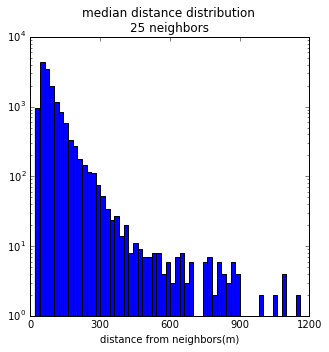

In [34]:
# Plot mean and median distribution of the distance of first n neighbors to each point in log scale
fig_b = plt.figure(figsize=(5,5))
ax1=fig_b.add_subplot(111)
binwidth=20
ax1.hist(median_distance, bins=np.arange(min(median_distance), max(median_distance) + binwidth, binwidth))
ax1.set_title('median distance distribution \n'+str(neighbors_number)+' neighbors')
ax1.set_xlim(0,1200)
ax1.set_xticks([0, 300, 600, 900,1200])
ax1.set_xlabel('distance from neighbors(m)')
plt.yscale('log', nonposy='clip')
plt.show()

# Median, MAD, and number of outliers

We compute the median value of the distance distribution.

Then we apply a function that returns a boolean mask of the good values, chosen based on their values with respect to the thershold and the MAD.

In our case, since we are dealing with an asymmetrical distribution we should consider the MAD for the two parts of the distribution, above and below the median. In particular, we want to remove outliers that are too far away from other data points, so we will look only at the MAD above the median (called highMAD).

In this case the good data will be:

good data < m+thresh x MADhigh

In [13]:
print np.amin(d_meters), np.amax(d_meters)
mediana=np.median(median_distance)
print mediana

0.0 2467.53782475
71.897436262


In [14]:
test=mad.MADhigh_mask(median_distance,thresh)
median_error=mad.MADhigh(median_distance)
control_parameter=mediana+median_error*thresh
print median_error, control_parameter

35.3782169903 354.923172184


In [15]:
#we save the value of the control parameters so that it can be accessed from another program
pickle.dump(control_parameter, open("geo_outliers\save_control_par"+" %.0f %.0f.p"% (central_lat,central_long), "wb" ) )

In [16]:
#Number of good data and of outliers found
print np.sum(test), median_distance.size-np.sum(test)

14623 232


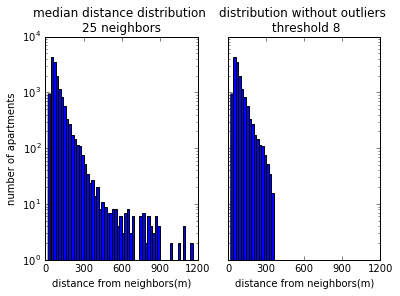

In [17]:
# Plot median distribution of the distance of first 10 neighbors before and after the MAD mask in log scale
f3, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
binwidth=20
ax1.hist(median_distance, bins=np.arange(min(median_distance), max(median_distance) + binwidth, binwidth))
ax1.set_title('median distance distribution \n'+str(neighbors_number)+' neighbors')
ax2.set_title('distribution without outliers \n threshold '+str(thresh))
ax1.set_xlim(0,1200)
ax1.set_xticks([0, 300, 600, 900,1200])
ax2.set_xlim(0,1200)
ax2.set_xticks([0, 300, 600, 900,1200])
ax1.set_xlabel('distance from neighbors(m)')
ax1.set_ylabel('number of apartments')
ax2.set_xlabel('distance from neighbors(m)')
ax2.hist(median_distance[test], bins=np.arange(min(median_distance[test]), max(median_distance[test]) + binwidth, binwidth))
plt.yscale('log', nonposy='clip')
fig.set_alpha(0) #transparent background
plt.draw()
f3.savefig('geo_outliers\log_hist_'+str(neighbors_number)+'neigh'+str(thresh)+'thresh.png',dpi=600)
#plt.show()

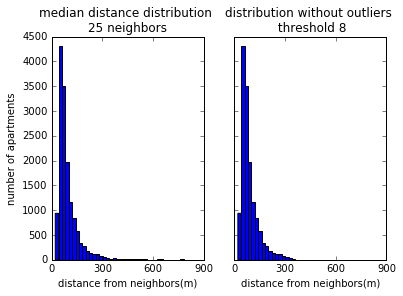

In [18]:
# Plot median distribution of the distance of first n neighbors before and after the MAD mask in linear scale
f3, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
binwidth=20
ax1.hist(median_distance, bins=np.arange(min(median_distance), max(median_distance) + binwidth, binwidth))
ax1.set_title('median distance distribution \n'+str(neighbors_number)+' neighbors')
ax2.set_title('distribution without outliers \n threshold '+str(thresh))
ax1.set_xlim(0,900)
ax1.set_xticks([0, 300, 600, 900])
ax2.set_xlim(0,900)
ax2.set_xticks([0, 300, 600, 900])
ax1.set_xlabel('distance from neighbors(m)')
ax1.set_ylabel('number of apartments')
ax2.set_xlabel('distance from neighbors(m)')
ax2.hist(median_distance[test], bins=np.arange(min(median_distance[test]), max(median_distance[test]) + binwidth, binwidth))
plt.show()

In [19]:
#ok now we find the outliers from the dataframe
outliers= np.ones(len(test),dtype=int)
outliers= (outliers-test.astype(int)).astype(bool)
print np.sum(outliers)


232


We can plot with basemap, an extension of matplotlib, the data on a simple map. For faster drawing change resolution to 'l'

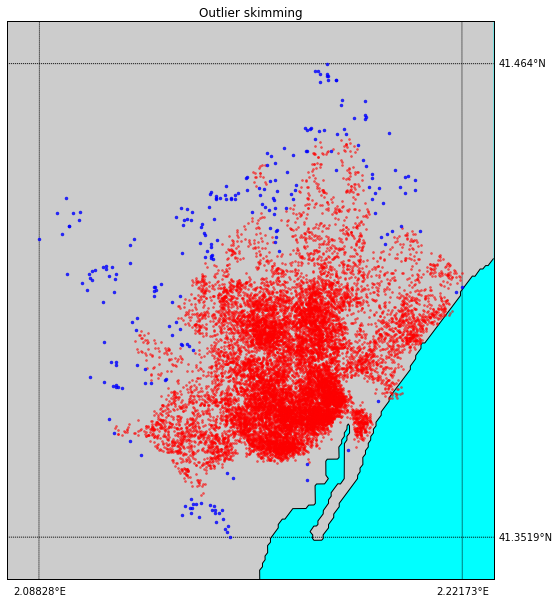

In [41]:
fig2 = plt.figure(figsize=(10,10))
# setup of basemap stereographic projection
m = Basemap(llcrnrlat=min_lat-0.01,llcrnrlon=min_long-0.01,urcrnrlat=max_lat+0.01,urcrnrlon=max_long+0.01,
            resolution='f',projection='stere',area_thresh = 0.01, lat_0=central_lat, lon_0=central_long)
m.drawcoastlines()
m.fillcontinents(color=[0.8,0.8,0.8],lake_color='aqua',zorder=0)
m.drawmapboundary(fill_color='aqua')

x_in, y_in = m(data.loc[:,('longitude')].values[test],data.loc[:,('latitude')].values[test])
m.plot(x_in,y_in,'.',markersize=4,color='r',alpha=0.6,zorder=10)
x_out, y_out = m(data.loc[:,('longitude')].values[outliers],data.loc[:,('latitude')].values[outliers])
m.plot(x_out,y_out,'.',markersize=6,color='b',alpha=0.8,zorder=10)

m.drawparallels([min_lat,max_lat],labels=[0,1,1,0] )
m.drawmeridians([min_long,max_long],labels=[1,0,0,1] )
plt.title('Outlier skimming',fontsize=12)
plt.show()

In [42]:
fig2.savefig('map'+str(neighbors_number)+'neigh'+str(thresh)+'thresh.png',dpi=600)

In [22]:
#let's save the ouliers in a dataframe for later visualization and drop them form the main dataframe
data_outliers=data.loc[outliers,:].copy()
data_outliers.to_csv("step2_outliers_neigh"+str(neighbors_number)+"threshold"+str(thresh)+".csv", sep=";", index=False, header=True)
data_clean=data.copy()
data_clean.drop(data.index[outliers], inplace=True)

In [23]:
#save the new dataframe to a file
#today=time.strftime("%Y%m%d_%H%M%S")
data_clean.to_csv("raw/step2_output.csv", sep=";", index=False, header=True)